In [50]:
# ============================================================
# MMDによる異常スコア解析テンプレ（①〜⑦ 完全版）
# - 時刻列・区間ラベル列は「ユーザーが明示指定」する前提（推定関数なし）
# - 周期性確認は “実務で一般的” な Welchスペクトル + ACF（自己相関）で判断
# - 周期がある場合は「周期rawベクトル化」or「周期FFT特徴」のどちらも選べる
# - 周期がない/扱わない場合は「そのまま」or「固定窓」で扱える
#
# 前提：
# - train/test は別入力（ファイルでもフォルダでもOK）
# - ラベル列は任意（無ければ None）
# ============================================================
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from scipy.signal import detrend, welch
from statsmodels.tsa.stattools import acf

from alibi_detect.cd import MMDDriftOnline



In [51]:

# ============================================================
# ① データの読み込み：ユーザー設定（このステップで必要なもの）
# ============================================================
TRAIN_INPUT = r".\\data\test_5\\SKAB\\X_train.csv"     # ファイル or フォルダ（直下の*.csv結合）
TEST_INPUT  = r".\\data\test_5\\SKAB\\X_test.csv"      # ファイル or フォルダ（直下の*.csv結合）



CSV_SEP = None                        # 指定したいなら "," ";" "\t" など
ENC_CANDIDATES = ["utf-8-sig", "utf-8", "cp932", "shift_jis"]

TIME_COL  = None                      # 例: "time" / "t" / "timestamp"。無いなら None
LABEL_COL = None                      # 例: "label"（複数ラベル可）。無いなら None


In [52]:

# ============================================================
# ① 実装（読み込み関数は最小限）
# ============================================================
def read_csv_easy(path: Path, sep=None, enc_candidates=None) -> pd.DataFrame:
    """
    CSVを壊れにくく読む。
    - 文字コード候補を順に試す
    - sep=None のときは python engine で区切り文字推定を試す
    """
    if enc_candidates is None:
        enc_candidates = ["utf-8-sig", "utf-8", "cp932", "shift_jis"]
    last_err = None
    for enc in enc_candidates:
        try:
            df = pd.read_csv(path, sep=None if sep is None else sep, engine="python", encoding=enc)
            df.columns = [str(c).strip() for c in df.columns]
            return df
        except Exception as e:
            last_err = e
    raise RuntimeError(f"読めませんでした: {path}\n最後のエラー: {last_err}")


def load_input(input_path: str | Path, sep=None, enc_candidates=None) -> pd.DataFrame:
    """
    入力がファイルならそのまま読む。
    入力がフォルダなら直下の *.csv を全部読んで結合する。
    """
    p = Path(input_path)
    if p.is_file():
        return read_csv_easy(p, sep=sep, enc_candidates=enc_candidates)
    if p.is_dir():
        files = sorted(p.glob("*.csv"))
        if len(files) == 0:
            raise RuntimeError(f"フォルダにCSVがありません: {p}")
        parts = [read_csv_easy(f, sep=sep, enc_candidates=enc_candidates) for f in files]
        return pd.concat(parts, ignore_index=True)
    raise RuntimeError(f"存在しません: {p}")


df_train_raw = load_input(TRAIN_INPUT, sep=CSV_SEP, enc_candidates=ENC_CANDIDATES)
df_test_raw  = load_input(TEST_INPUT,  sep=CSV_SEP, enc_candidates=ENC_CANDIDATES)

print("df_train_raw:", df_train_raw.shape)
print("df_test_raw :", df_test_raw.shape)

if TIME_COL is not None and TIME_COL not in df_train_raw.columns:
    raise ValueError(f"TIME_COL='{TIME_COL}' が train に存在しません。列名を確認してください。")
if TIME_COL is not None and TIME_COL not in df_test_raw.columns:
    raise ValueError(f"TIME_COL='{TIME_COL}' が test に存在しません。列名を確認してください。")

if LABEL_COL is not None and LABEL_COL not in df_train_raw.columns:
    raise ValueError(f"LABEL_COL='{LABEL_COL}' が train に存在しません。列名を確認してください。")
if LABEL_COL is not None and LABEL_COL not in df_test_raw.columns:
    raise ValueError(f"LABEL_COL='{LABEL_COL}' が test に存在しません。列名を確認してください。")



df_train_raw: (5643, 8)
df_test_raw : (41163, 8)


[INFO] numeric candidates (train basis): 8 columns
['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']


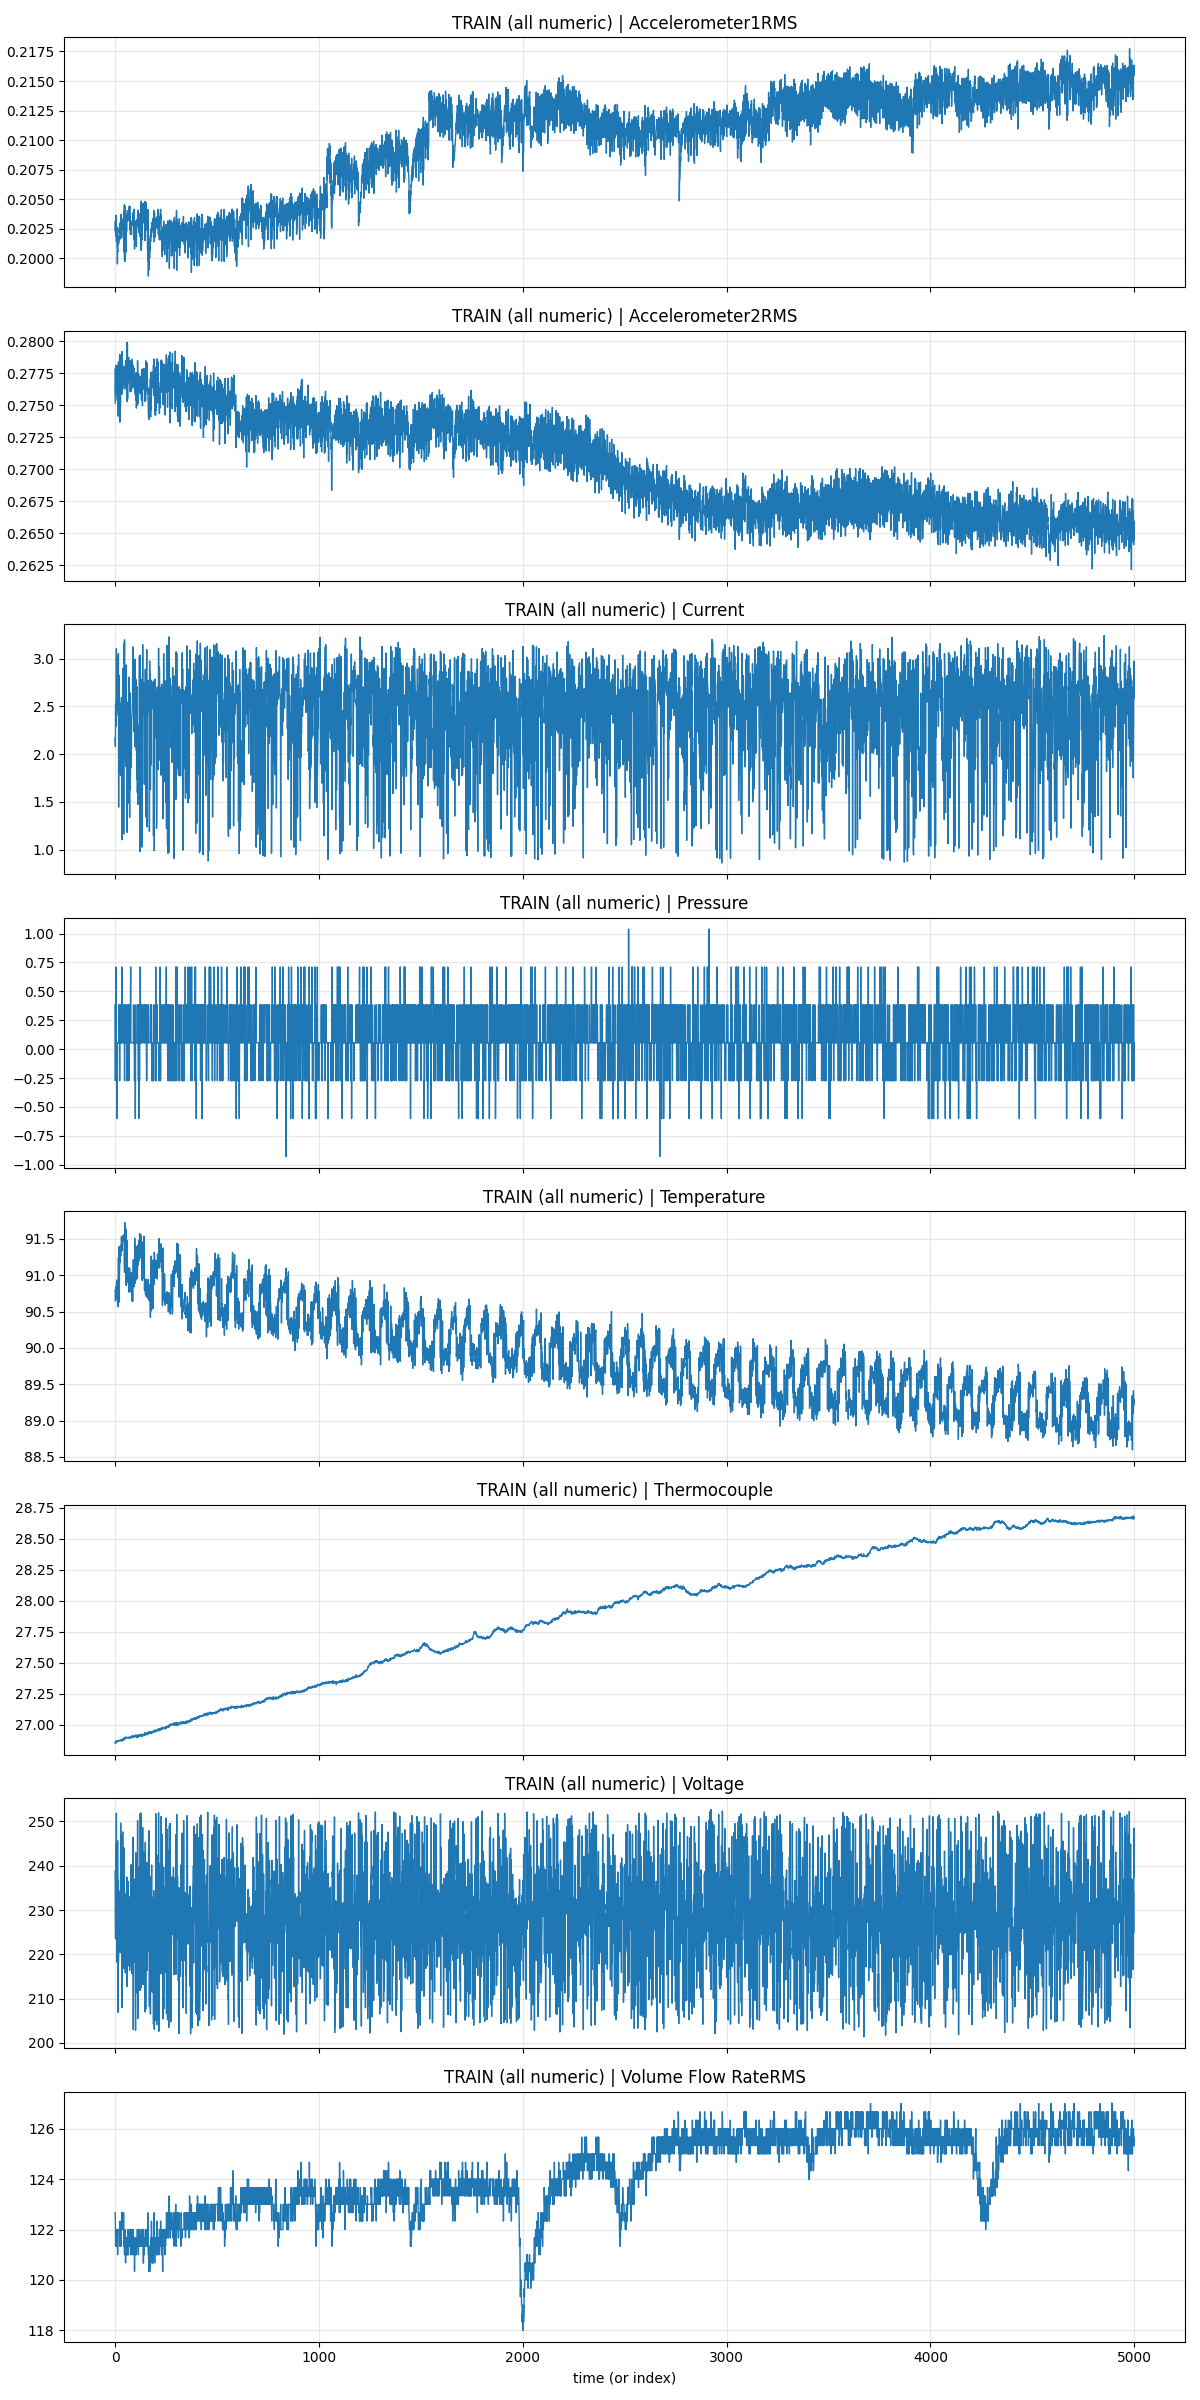

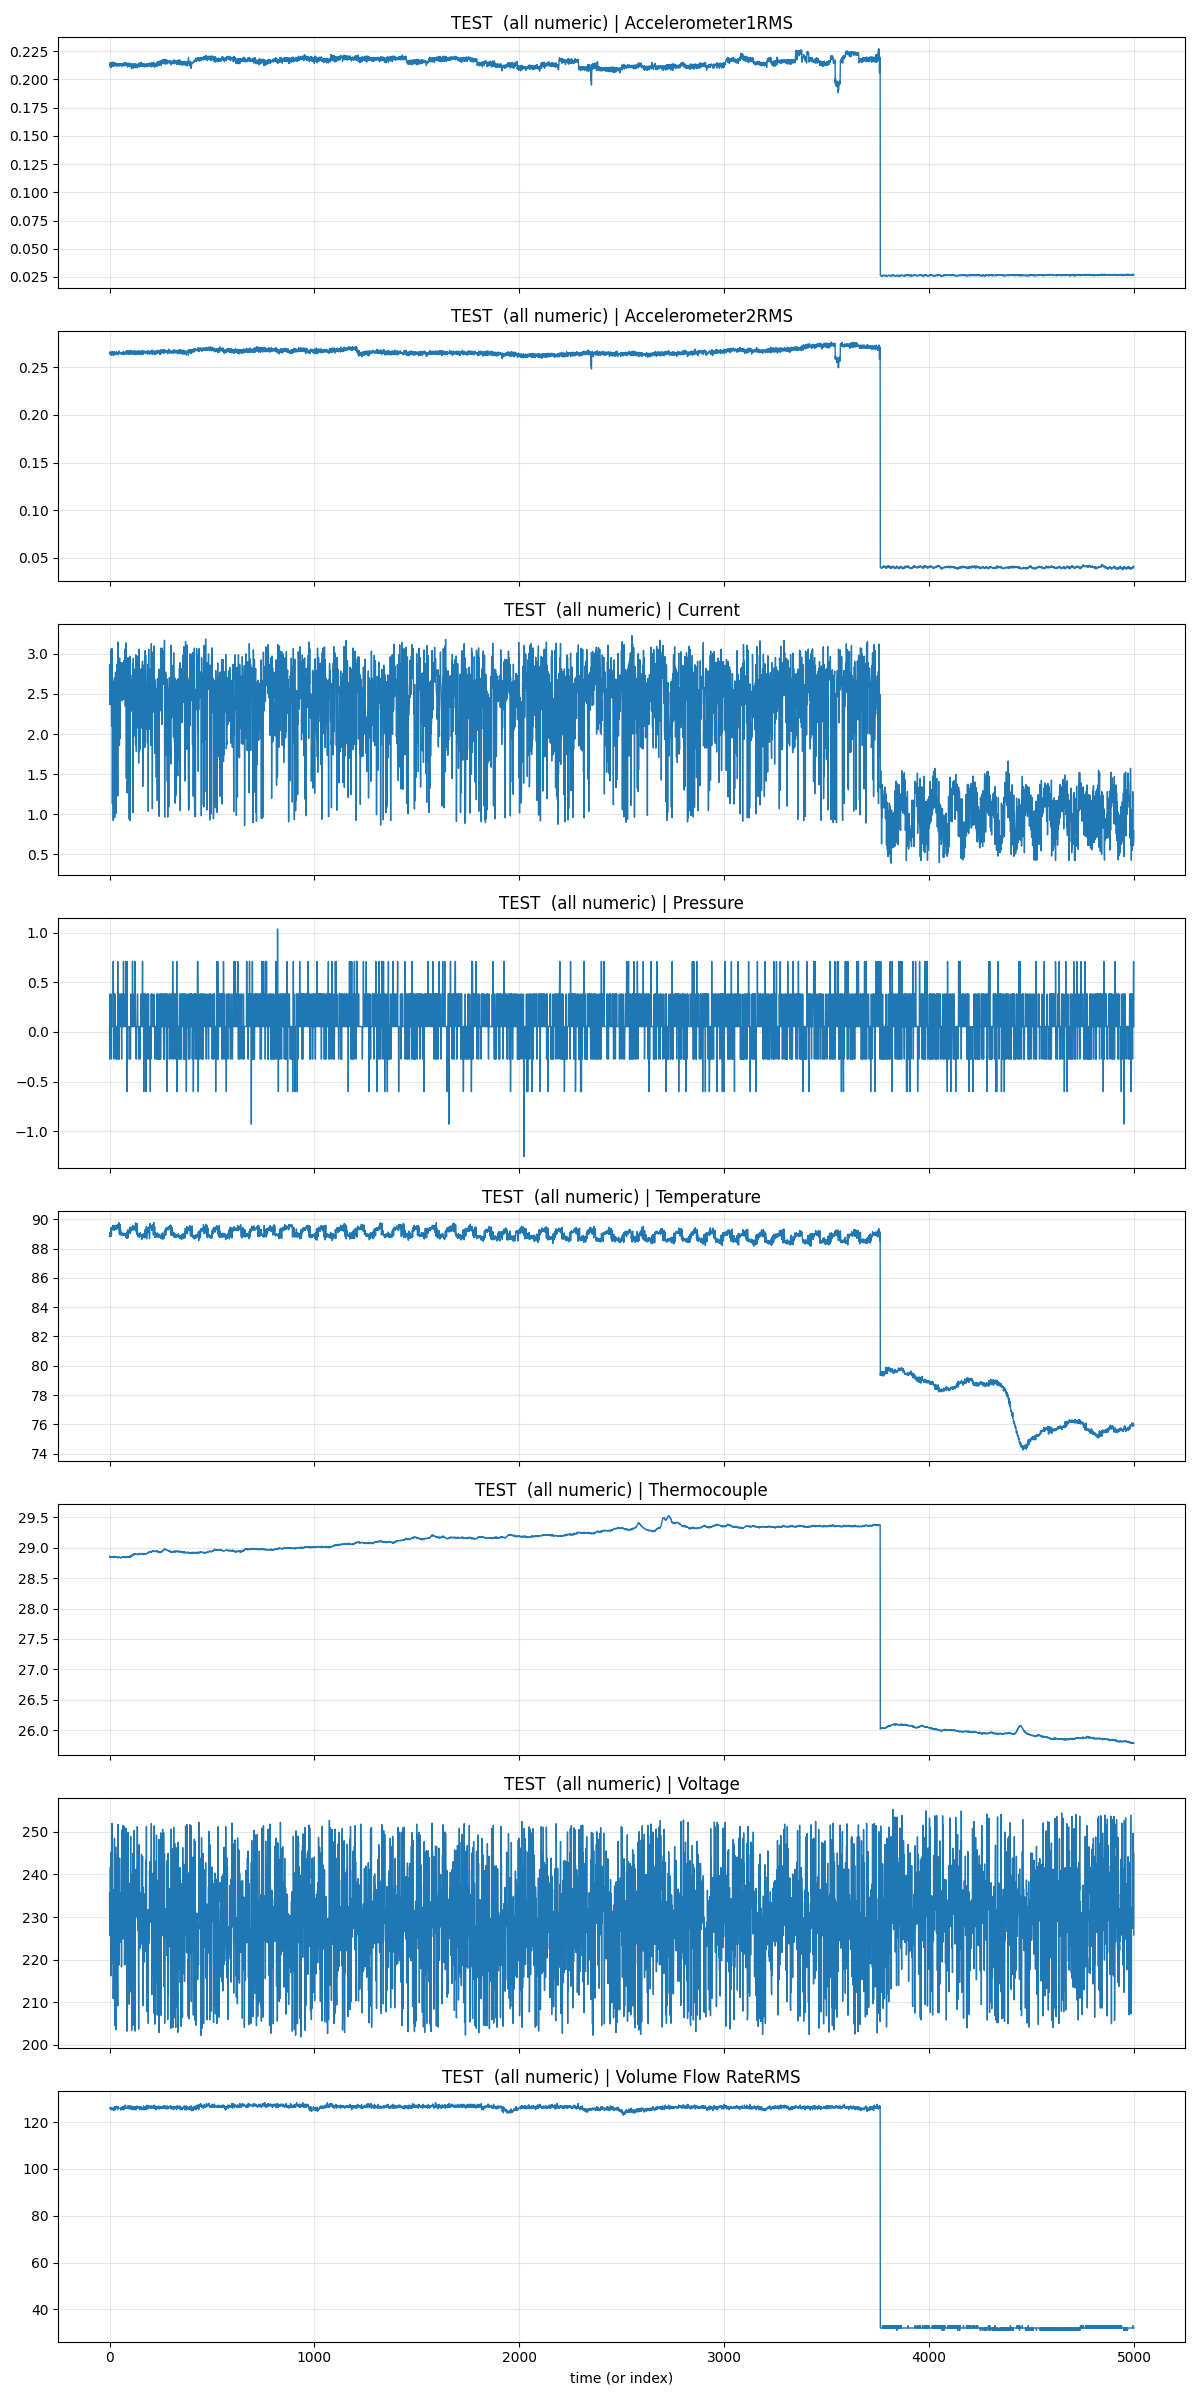

In [53]:
# ============================================================
# ② 可視化：ユーザー設定
# ============================================================
PLOT_N = 5000

# あなたが指定する（NoneでもOK）
TIME_COL  = None      # 例: "time"   / 無ければ None
LABEL_COL = None      # 例: "label"  / 無ければ None


# ============================================================
# ② すべての「数値列」を対象にする（除外なし）
# ============================================================
def get_numeric_feature_candidates(df: pd.DataFrame) -> list[str]:
    return df.select_dtypes(include=[np.number]).columns.tolist()


# ============================================================
# ② 実装：全列プロット（ラベルがあれば区間色分け）
# ============================================================
def plot_timeseries_simple(df: pd.DataFrame,
                           cols: list[str],
                           *,
                           title: str,
                           time_col: str | None,
                           label_col: str | None,
                           n: int = 5000):
    n = min(n, len(df))

    # time軸
    if time_col is None:
        t = np.arange(n)
    else:
        t = pd.to_numeric(df[time_col], errors="coerce").to_numpy()[:n]
        if np.any(~np.isfinite(t)):
            t = np.arange(n)

    # label（任意）
    y = None
    if label_col is not None:
        y = df[label_col].iloc[:n].astype(str).to_numpy()

    fig, axes = plt.subplots(len(cols), 1, figsize=(12, 3.0 * len(cols)), sharex=True)
    if len(cols) == 1:
        axes = [axes]

    for ax, c in zip(axes, cols):
        x = pd.to_numeric(df[c], errors="coerce").interpolate(limit_direction="both").iloc[:n].to_numpy()
        ax.plot(t, x, linewidth=1.0)
        ax.set_title(f"{title} | {c}")
        ax.grid(True, alpha=0.3)

        # ラベル区間の背景色
        if y is not None:
            change = np.flatnonzero(y[1:] != y[:-1]) + 1
            bounds = np.r_[0, change, len(y)]

            colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
            if len(colors) == 0:
                colors = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]

            uniq = pd.unique(y)
            color_map = {lab: colors[i % len(colors)] for i, lab in enumerate(uniq)}

            for i in range(len(bounds) - 1):
                a, b = bounds[i], bounds[i + 1]
                lab = y[a]
                x0 = t[a]
                x1 = t[b - 1] if (b - 1) < len(t) else t[-1]
                ax.axvspan(x0, x1, alpha=0.10, color=color_map[lab])

    axes[-1].set_xlabel("time (or index)")
    plt.tight_layout()
    plt.show()


# ============================================================
# ② 実行：全数値列をプロット
# ============================================================
ALL_FEATURE_CANDIDATES = get_numeric_feature_candidates(df_train_raw)

print(f"[INFO] numeric candidates (train basis): {len(ALL_FEATURE_CANDIDATES)} columns")
print(ALL_FEATURE_CANDIDATES)

plot_timeseries_simple(df_train_raw, ALL_FEATURE_CANDIDATES, title="TRAIN (all numeric)", time_col=TIME_COL, label_col=LABEL_COL, n=PLOT_N)
plot_timeseries_simple(df_test_raw,  ALL_FEATURE_CANDIDATES, title="TEST  (all numeric)", time_col=TIME_COL, label_col=LABEL_COL, n=PLOT_N)


In [54]:

# ============================================================
# ③ 周期性の有無の確認：ユーザー設定
# ============================================================
DO_PERIOD_CHECK = True
PERIOD_PREPROCESS = "detrend"  # "detrend" / "diff" / "none"

FS = 1.0
MIN_PERIOD = 5
MAX_PERIOD = 500

WELCH_NPERSEG = 1024
WELCH_NOVERLAP = None

ACF_ALPHA = 0.01

MIN_PSD_PEAK_RATIO = 5.0
MIN_ACF_PEAK = 0.2

# ============================================================
# ③ 実装（Welch PSD + ACF）
# ============================================================
def _prep_for_periodicity(s: pd.Series, preprocess: str) -> np.ndarray:
    x = pd.to_numeric(s, errors="coerce").interpolate(limit_direction="both").to_numpy(dtype=float)

    if preprocess == "detrend":
        x = detrend(x, type="linear")
    elif preprocess == "diff":
        x = np.diff(x)

    x = x - np.mean(x)
    x = x / (np.std(x) + 1e-12)
    return x

def periodicity_welch_acf_columns(
    df: pd.DataFrame,
    cols: list[str],
    *,
    preprocess: str,
    fs: float,
    min_period: int,
    max_period: int,
    welch_nperseg: int,
    welch_noverlap: int | None,
    acf_alpha: float,
    min_psd_peak_ratio: float,
    min_acf_peak: float
) -> pd.DataFrame:

    rows = []
    for c in cols:
        x = _prep_for_periodicity(df[c], preprocess=preprocess)
        n = len(x)

        if n < max(60, 5 * min_period):
            rows.append({
                "col": c, "n": int(n),
                "best_period_psd": np.nan, "psd_peak_ratio": np.nan,
                "best_period_acf": np.nan, "acf_peak": np.nan,
                "is_periodic": False
            })
            continue

        nperseg = int(min(welch_nperseg, n))
        if nperseg < 8:
            rows.append({
                "col": c, "n": int(n),
                "best_period_psd": np.nan, "psd_peak_ratio": np.nan,
                "best_period_acf": np.nan, "acf_peak": np.nan,
                "is_periodic": False
            })
            continue

        noverlap = None if welch_noverlap is None else int(min(welch_noverlap, nperseg - 1))

        f, Pxx = welch(
            x, fs=fs, window="hann",
            nperseg=nperseg, noverlap=noverlap,
            detrend=False, scaling="spectrum", average="mean"
        )

        # DC除外
        f, Pxx = f[1:], Pxx[1:]
        period = fs / (f + 1e-300)

        maxP = min(max_period, n // 2)
        mask = (period >= min_period) & (period <= maxP)

        if not np.any(mask):
            best_period_psd = np.nan
            psd_peak_ratio = np.nan
        else:
            P2 = Pxx[mask]
            per2 = period[mask]
            j = int(np.argmax(P2))
            best_period_psd = float(per2[j])
            psd_peak_ratio = float(np.max(P2) / (np.median(P2) + 1e-12))

        # ACF
        nlags = int(min(maxP, n - 1))
        acf_vals, confint = acf(x, nlags=nlags, fft=True, alpha=acf_alpha)

        lags = np.arange(len(acf_vals))
        lag_mask = (lags >= min_period) & (lags <= maxP)
        lags2 = lags[lag_mask]
        a2 = acf_vals[lag_mask]
        ci2 = confint[lag_mask]

        sig = (ci2[:, 0] > 0) | (ci2[:, 1] < 0)
        sig_pos = sig & (a2 > 0)

        if np.any(sig_pos):
            idx = int(np.argmax(a2[sig_pos]))
            best_period_acf = float(lags2[sig_pos][idx])
            acf_peak = float(a2[sig_pos][idx])
        else:
            best_period_acf = np.nan
            acf_peak = np.nan

        cond_psd = np.isfinite(psd_peak_ratio) and (psd_peak_ratio >= min_psd_peak_ratio)
        cond_acf = np.isfinite(acf_peak) and (acf_peak >= min_acf_peak) and np.isfinite(best_period_acf)
        is_periodic = bool(cond_psd and cond_acf)

        rows.append({
            "col": c, "n": int(n),
            "best_period_psd": best_period_psd,
            "psd_peak_ratio": psd_peak_ratio,
            "best_period_acf": best_period_acf,
            "acf_peak": acf_peak,
            "is_periodic": is_periodic
        })

    out = (
        pd.DataFrame(rows)
        .sort_values(["is_periodic", "psd_peak_ratio"], ascending=[False, False])
        .reset_index(drop=True)
    )
    return out


# ③：全列に周期性チェック
period_summary = None
if DO_PERIOD_CHECK:
    period_summary = periodicity_welch_acf_columns(
        df_train_raw,
        ALL_FEATURE_CANDIDATES,
        preprocess=PERIOD_PREPROCESS,
        fs=FS,
        min_period=MIN_PERIOD,
        max_period=MAX_PERIOD,
        welch_nperseg=WELCH_NPERSEG,
        welch_noverlap=WELCH_NOVERLAP,
        acf_alpha=ACF_ALPHA,
        min_psd_peak_ratio=MIN_PSD_PEAK_RATIO,
        min_acf_peak=MIN_ACF_PEAK
    )
    print("\n=== Periodicity summary (TRAIN basis; all numeric cols) ===")
    # 表示（保存ではなく表示）
    display(period_summary)  # Jupyter前提。displayが無ければ print(period_summary)



=== Periodicity summary (TRAIN basis; all numeric cols) ===


,col,n,best_period_psd,psd_peak_ratio,best_period_acf,acf_peak,is_periodic
0,Thermocouple,5643,341.333333,922.873798,5.0,0.991741,True
1,Temperature,5643,85.333333,258.671122,5.0,0.655059,True
2,Volume Flow RateRMS,5643,341.333333,200.066583,5.0,0.798744,True
3,Accelerometer1RMS,5643,341.333333,39.635255,8.0,0.804209,True
4,Accelerometer2RMS,5643,256.000000,7.812576,12.0,0.549911,True
5,Current,5643,40.960000,3.610155,6.0,0.070527,False
6,Pressure,5643,6.206061,2.059271,104.0,0.048148,False
7,Voltage,5643,6.522293,1.997668,66.0,0.038195,False


| 列名 | 何を表すか | 良い（周期性がありそう） | 悪い（周期性が薄い/不明） | 典型的な原因/対処 |
|---|---|---|---|---|
| `col` | 対象センサ列名 | ― | ― | FEATURE_COLS と対応 |
| `n` | 周期判定に使った点数（前処理後） | 大きいほど信頼性が上がる（目安：`>= 5×想定周期` 以上） | 小さいと判定が不安定（`is_periodic=False` になりやすい） | データ長を増やす／短い区間を除外 |
| `best_period_psd` | Welchスペクトル（周波数解析）で最も強い周期（単位：サンプル数） | 値が「想定周期（例：100点/周期）」に近い | 値が毎回バラバラ、または `NaN` | ドリフトが強い→`PERIOD_PREPROCESS="detrend"`、ノイズ大→`WELCH_NPERSEG` を増やす（ただしデータ長以内） |
| `psd_peak_ratio` | スペクトルのピークの目立ち度（`max(PSD)/median(PSD)`） | 大きいほど周期成分が目立つ（テンプレ閾値：`>= 5.0`） | 1〜数程度（ピークが目立たない） | 周期が弱い／複数周期が混在／ノイズが支配的。対処：`detrend`、区間を分けて再評価、フィルタ検討 |
| `best_period_acf` | 自己相関（ACF）で最も強い周期（単位：サンプル数） | `best_period_psd` と近い値になりやすい | `NaN`、または極端に小さい/大きい値 | 位相が揺れる・周期が揺らぐとACFが弱くなる。対処：区間を短くして評価、周期推定を別途固定 |
| `acf_peak` | `best_period_acf` での自己相関の高さ（0〜1） | 大きいほど周期がはっきり（テンプレ閾値：`>= 0.2`） | 0に近い（有意ピークが出ないと `NaN` もあり得る） | トレンドや段差が強い／周期が非定常。対処：`detrend` or `diff`、区間分割 |
| `is_periodic` | 機械判定（テンプレ条件：`psd_peak_ratio>=5` かつ `acf_peak>=0.2`） | `True` → “周期性あり” と扱って周期化（cycle）を検討 | `False` → 周期化しない（as_is / window）を優先 | 閾値は用途で調整：見逃しを減らす→閾値を下げる、誤検知を減らす→上げる |

## 実務での読み方（最短手順）
1. まず `is_periodic` を見る：`True` の列は周期処理候補。  
2. `best_period_psd` と `best_period_acf` が「近い」か確認：近いほど信頼。  
3. 周期長を決める：`best_period_acf`（または `best_period_psd`）を丸めて採用。  
   - 例：`best_period_acf=99.6` → 周期長 `100`  
4. `False` の列は “周期なし” として同じパイプラインに入れるなら  
   - `SAMPLE_MODE="window_raw"`（固定窓）  
   - もしくは `SAMPLE_MODE="as_is"`（行=時刻点）  
   を選ぶのが無難。

## よくある判定パターン
- **強い周期**：`psd_peak_ratio` が大きい & `acf_peak` も大きい & `best_period_psd ≈ best_period_acf`  
- **トレンドで偽の周期**：`detrend="none"` だと PSD は強く見えるが ACF が合わない（または周期が不自然）  
- **周期が揺らぐ（回転数変動など）**：PSDはそこそこ、ACFが弱く `is_periodic=False` になりがち（区間を短くすると改善することがある）


In [55]:
# ============================================================
# ③の結果を見て、ここで初めて選ぶ（済）
# FEATURE_COLS = ["Current", "Pressure"]
# ============================================================

FEATURE_COLS = ["Current", "Voltage"]  # 例：あなたが決める


# ③で選んだ特徴量だけの DataFrame を作る（←④が使うのはこれ）
X_train_df = df_train_raw[FEATURE_COLS].copy()
X_test_df  = df_test_raw[FEATURE_COLS].copy()

# （任意）数値化＋欠損補間（混入文字や欠損があると StandardScaler が落ちるため）
# X_train_df = X_train_df.apply(pd.to_numeric, errors="coerce").interpolate(limit_direction="both")
# X_test_df  = X_test_df.apply(pd.to_numeric, errors="coerce").interpolate(limit_direction="both")

print("X_train_df:", X_train_df.shape)
display(X_train_df.head())
print("X_test_df :", X_test_df.shape)
display(X_test_df.head())


X_train_df: (5643, 2)


,Current,Voltage
0,2.16975,238.852
1,2.07999,227.943
2,2.52577,223.486
3,2.49742,244.904
4,2.29194,239.196


X_test_df : (41163, 2)


,Current,Voltage
0,2.86279,235.587
1,2.47970,225.709
2,2.36692,230.336
3,2.75429,229.382
4,2.60747,241.726


In [56]:
# ============================================================
# ③ 周期性があれば、窓数（周期長）を設定してデータ行列を作り直す：ユーザー設定
# ============================================================
# 何を1サンプルとするか（実務でよくある選択肢）
# - "as_is"     : 行=時刻点（そのまま N×M）
# - "cycle_raw" : 1周期をベクトル化（1行=1周期, 次元=L*M）
# - "cycle_fft" : 1周期をFFT特徴へ（1行=1周期, 次元=K*M, 位相ズレに比較的強い）
# - "window_raw": 固定窓をベクトル化（周期が無い/不明の代替、次元=window_len*M）
SAMPLE_MODE = "cycle_fft"

# 周期長（点数）
# - 既知なら手入力が最も実務的（例：100点/周期）
# - 不明なら None にして、period_summary から自動で中央値を採用する
CYCLE_LEN = 40   # 例：100点ごとに周期があるなら 100。自動にしたいなら None。

# FFT特徴量の数（DC除外後の 1..K を使用）
CYCLE_FFT_K = 20

# 周期ごとに標準化（各周期・各列を平均0/分散1にして “形” 寄りにする）
# - True: 振幅差の影響が弱まり形状変化が目立つ
# - False: 振幅変化も検知対象に含めやすい
PER_CYCLE_NORM = False

# 固定窓（SAMPLE_MODE="window_raw" のときに使用）
WINDOW_LEN = 200
WINDOW_STRIDE = 200


# ============================================================
# ③ 実装：サンプル行列化（labelは窓/周期内の最多ラベルに圧縮）
# ============================================================
def _mode_label(arr: np.ndarray) -> str | None:
    y = np.asarray(arr)
    y = y[~pd.isna(y)]
    if len(y) == 0:
        return None
    y = y.astype(str)
    vals, cnts = np.unique(y, return_counts=True)
    return str(vals[int(np.argmax(cnts))])


def build_samples(df: pd.DataFrame,
                  feature_cols: list[str],
                  *,
                  time_col: str | None,
                  label_col: str | None,
                  mode: str,
                  cycle_len: int,
                  cycle_fft_k: int,
                  per_cycle_norm: bool,
                  window_len: int,
                  window_stride: int):
    """
    返り値：
      X_df : (n_samples, n_features) の DataFrame（MMDに入れる）
      t_s  : (n_samples,) サンプル時刻（周期/窓なら先頭時刻）
      y_s  : (n_samples,) サンプルラベル（無ければ None）
    """
    # 特徴列を数値化→補間（行が落ちないようにする）
    X0 = df[feature_cols].apply(pd.to_numeric, errors="coerce").interpolate(limit_direction="both")
    X = X0.to_numpy(dtype=float)
    N, M = X.shape

    # 時刻
    if time_col is None:
        t_raw = np.arange(N)
    else:
        t_raw = pd.to_numeric(df[time_col], errors="coerce").to_numpy()
        if np.any(~np.isfinite(t_raw)):
            t_raw = np.arange(N)

    # ラベル
    y_raw = None
    if label_col is not None:
        y_raw = df[label_col].to_numpy()

    mode = mode.lower().strip()

    # (a) そのまま
    if mode == "as_is":
        X_df = pd.DataFrame(X, columns=feature_cols)
        return X_df, t_raw, y_raw

    # (b)(c) 周期
    if mode in ["cycle_raw", "cycle_fft"]:
        L = int(cycle_len)
        C = N // L
        if C <= 0:
            raise ValueError(f"N={N} が cycle_len={L} より短いので周期化できません。")

        Xc = X[:C*L].reshape(C, L, M)          # (C, L, M)
        t_s = t_raw[:C*L].reshape(C, L)[:, 0]  # 各周期先頭

        y_s = None
        if y_raw is not None:
            yw = y_raw[:C*L].reshape(C, L)
            y_s = np.array([_mode_label(w) for w in yw], dtype=object)

        if per_cycle_norm:
            mu = Xc.mean(axis=1, keepdims=True)
            sd = Xc.std(axis=1, keepdims=True) + 1e-12
            Xc = (Xc - mu) / sd

        if mode == "cycle_raw":
            X_feat = Xc.reshape(C, L*M)
            cols = [f"{col}_t{i:03d}" for col in feature_cols for i in range(L)]
            return pd.DataFrame(X_feat, columns=cols), t_s, y_s

        if mode == "cycle_fft":
            # rfft → 振幅
            F = np.fft.rfft(Xc, axis=1)  # (C, L//2+1, M)
            mag = np.abs(F)

            max_k = mag.shape[1] - 1
            K = int(min(cycle_fft_k, max_k))
            if K <= 0:
                raise ValueError("cycle_fft_k が小さすぎます（1以上）。")

            mag_sel = mag[:, 1:1+K, :]     # DC除外
            X_feat = mag_sel.reshape(C, K*M)
            cols = [f"{col}_fft{i:02d}" for col in feature_cols for i in range(1, 1+K)]
            return pd.DataFrame(X_feat, columns=cols), t_s, y_s

    # (d) 固定窓
    if mode == "window_raw":
        L = int(window_len)
        S = int(window_stride)
        if N < L:
            raise ValueError(f"N={N} が window_len={L} より短いので窓化できません。")

        idx0 = np.arange(0, N - L + 1, S)
        X_list, t_list, y_list = [], [], []

        for a in idx0:
            b = a + L
            Xw = X[a:b]              # (L, M)
            X_list.append(Xw.reshape(L*M))
            t_list.append(t_raw[a])  # 窓先頭
            if y_raw is not None:
                y_list.append(_mode_label(y_raw[a:b]))

        X_feat = np.vstack(X_list)
        cols = [f"{col}_w{i:03d}" for col in feature_cols for i in range(L)]
        X_df = pd.DataFrame(X_feat, columns=cols)
        t_s = np.array(t_list)
        y_s = np.array(y_list, dtype=object) if y_raw is not None else None
        return X_df, t_s, y_s

    raise ValueError('SAMPLE_MODE は "as_is" / "cycle_raw" / "cycle_fft" / "window_raw" のいずれかです。')


# ③：周期長の自動決定（必要なときだけ）
if SAMPLE_MODE in ["cycle_raw", "cycle_fft"] and CYCLE_LEN is None:
    if period_summary is None:
        raise ValueError("CYCLE_LEN を自動決定するには DO_PERIOD_CHECK=True が必要です。")
    cand = period_summary.loc[period_summary["is_periodic"] == True, "best_period_acf"].dropna().to_numpy()
    if len(cand) == 0:
        raise ValueError("周期性ありと判定された列が無いので自動決定できません。CYCLE_LENを手入力してください。")
    CYCLE_LEN = int(np.round(np.median(cand)))
    print(f"[auto] CYCLE_LEN = {CYCLE_LEN}")

X_train_df, t_train_s, y_train_s = build_samples(
    df_train_raw, FEATURE_COLS,
    time_col=TIME_COL,
    label_col=LABEL_COL,
    mode=SAMPLE_MODE,
    cycle_len=int(CYCLE_LEN) if CYCLE_LEN is not None else 0,
    cycle_fft_k=CYCLE_FFT_K,
    per_cycle_norm=PER_CYCLE_NORM,
    window_len=WINDOW_LEN,
    window_stride=WINDOW_STRIDE
)

X_test_df, t_test_s, y_test_s = build_samples(
    df_test_raw, FEATURE_COLS,
    time_col=TIME_COL,
    label_col=LABEL_COL,
    mode=SAMPLE_MODE,
    cycle_len=int(CYCLE_LEN) if CYCLE_LEN is not None else 0,
    cycle_fft_k=CYCLE_FFT_K,
    per_cycle_norm=PER_CYCLE_NORM,
    window_len=WINDOW_LEN,
    window_stride=WINDOW_STRIDE
)

print("\n=== After sample building ===")
print("X_train_df:", X_train_df.shape, " (1行=1サンプル)")
print("X_test_df :", X_test_df.shape)
print("train labels:", "あり" if y_train_s is not None else "なし")
print("test  labels:", "あり" if y_test_s is not None else "なし")



=== After sample building ===
X_train_df: (141, 40)  (1行=1サンプル)
X_test_df : (1029, 40)
train labels: なし
test  labels: なし


In [57]:

# ============================================================
# ④ 標準化：ユーザー設定（このステップで必要なもの）
# ============================================================
DO_STANDARDIZE = True


# ============================================================
# ④ 実装
# ============================================================
if DO_STANDARDIZE:
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train_df.values)
    X_test_std  = scaler.transform(X_test_df.values)

    print("\n=== Standardization check (TRAIN) ===")
    print("shape:", X_train_std.shape)
    print("mean(first 10):", np.round(X_train_std.mean(axis=0)[:10], 6))
    print("std (first 10):", np.round(X_train_std.std(axis=0, ddof=0)[:10], 6))
else:
    scaler = None
    X_train_std = X_train_df.values
    X_test_std  = X_test_df.values



=== Standardization check (TRAIN) ===
shape: (141, 40)
mean(first 10): [-0.  0. -0. -0. -0. -0.  0.  0. -0.  0.]
std (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [58]:


# ============================================================
# ⑤ MMDのモデル学習：ユーザー設定（このステップで必要なもの）
# ============================================================
BACKEND = "tensorflow"

# 参照分布（正常）に使うサンプル数
N_REF =120
# オンラインで比較する窓サイズ（直近何サンプルでMMDを計算するか）
WINDOW_SIZE = 10

# 誤報率を抑える方向に効く調整パラメータ（大きいほど誤報減りやすい傾向）
ERT = 60.0

# 閾値推定の反復（大きいほど安定、重い）
N_BOOTSTRAPS = 1000


# ============================================================
# ⑤ 実装
# ============================================================
# TensorFlow backend のときは float32 の方が無難
X_train_std = np.asarray(X_train_std, dtype=np.float32)
X_test_std  = np.asarray(X_test_std,  dtype=np.float32)

n_ref = int(min(N_REF, len(X_train_std)))
if n_ref < max(50, WINDOW_SIZE):
    raise ValueError(
        f"参照が小さすぎます: n_ref={n_ref}, window_size={WINDOW_SIZE}\n"
        "N_REF を増やすか WINDOW_SIZE を小さくしてください。"
    )

x_ref = X_train_std[:n_ref]

cd = MMDDriftOnline(
    x_ref=x_ref,
    ert=ERT,
    window_size=WINDOW_SIZE,
    backend=BACKEND,
    n_bootstraps=N_BOOTSTRAPS,
    verbose=True
)



Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]



[TRAIN check] ratio(mmd2<=threshold)=1.000, false_alarm_rate=0.000


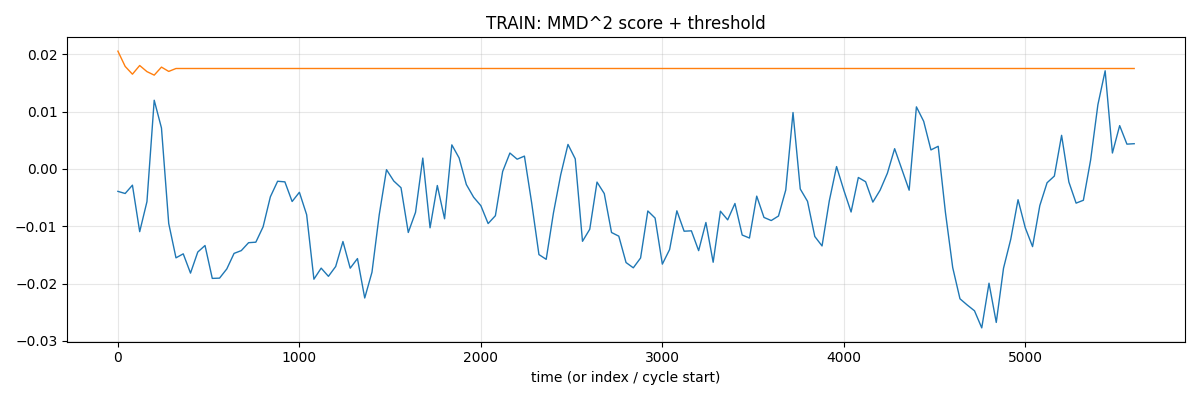

In [59]:

# ============================================================
# ⑥ 学習データで評価値確認：ユーザー設定（このステップで必要なもの）
# ============================================================
# 参照に使った部分（x_ref）を除いてチェックしたい場合 True
# True の方が “誤報率” の読みが素直になりやすい
TRAIN_CHECK_USE_HOLDOUT = False

# 閾値線や is_drift を “表示・集計” するか
# スコアだけ見たいなら False（ただし内部でthresholdは計算される）
USE_THRESHOLD = True

# 流すサンプル数を制限したい場合（巨大データ対策）
MAX_STREAM_TRAIN = None  # 例: 20000。制限しないなら None。


# ============================================================
# ⑥ 実装：ストリームログ化 + 可視化
# ============================================================
def run_stream(detector, X_stream: np.ndarray, t_axis: np.ndarray | None, y_axis: np.ndarray | None, max_n: int | None) -> pd.DataFrame:
    n = X_stream.shape[0]
    if max_n is not None:
        n = min(n, int(max_n))

    rec = []
    for i in range(n):
        x_t = X_stream[i]  # (D,)
        out = detector.predict(x_t, return_test_stat=True)
        d = out["data"]
        rec.append({
            "i": i,
            "t": float(t_axis[i]) if t_axis is not None else float(i),
            "mmd2": float(d.get("test_stat", np.nan)),
            "threshold": float(d.get("threshold", np.nan)),
            "is_drift": int(d.get("is_drift", 0)),
            "label": (str(y_axis[i]) if (y_axis is not None and i < len(y_axis) and y_axis[i] is not None) else None)
        })
    return pd.DataFrame(rec)


def plot_mmd_log(df_log: pd.DataFrame, title: str, use_threshold: bool, shade_labels: bool):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(df_log["t"], df_log["mmd2"], linewidth=1.0)
    if use_threshold:
        ax.plot(df_log["t"], df_log["threshold"], linewidth=1.0)

    ax.set_title(title)
    ax.set_xlabel("time (or index / cycle start)")
    ax.grid(True, alpha=0.3)

    if shade_labels and ("label" in df_log.columns) and df_log["label"].notna().any():
        y = df_log["label"].astype(str).to_numpy()
        t = df_log["t"].to_numpy()
        change = np.flatnonzero(y[1:] != y[:-1]) + 1
        bounds = np.r_[0, change, len(y)]

        colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
        if len(colors) == 0:
            colors = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
        uniq = pd.unique(y)
        color_map = {lab: colors[i % len(colors)] for i, lab in enumerate(uniq)}

        for k in range(len(bounds) - 1):
            a, b = bounds[k], bounds[k + 1]
            lab = y[a]
            ax.axvspan(t[a], t[b - 1] if (b - 1) < len(t) else t[-1], alpha=0.12, color=color_map[lab])

    plt.tight_layout()
    plt.show()


X_train_check = X_train_std[n_ref:] if (TRAIN_CHECK_USE_HOLDOUT and len(X_train_std) > n_ref) else X_train_std
t_train_check = t_train_s[n_ref:]   if (TRAIN_CHECK_USE_HOLDOUT and len(t_train_s) > n_ref)   else t_train_s
y_train_check = y_train_s[n_ref:]   if (TRAIN_CHECK_USE_HOLDOUT and (y_train_s is not None) and len(y_train_s) > n_ref) else y_train_s

df_log_train = run_stream(cd, X_train_check, t_train_check, y_train_check, MAX_STREAM_TRAIN)

if USE_THRESHOLD:
    ok_ratio = np.mean(df_log_train["mmd2"].values <= df_log_train["threshold"].values)
    fa_rate  = np.mean(df_log_train["is_drift"].values == 1)
    print(f"\n[TRAIN check] ratio(mmd2<=threshold)={ok_ratio:.3f}, false_alarm_rate={fa_rate:.3f}")
else:
    print("\n[TRAIN check] スコアのみ解析（threshold/is_driftは表示・集計しない設定）")

plot_mmd_log(df_log_train, title="TRAIN: MMD^2 score" + (" + threshold" if USE_THRESHOLD else ""),
             use_threshold=USE_THRESHOLD, shade_labels=False)



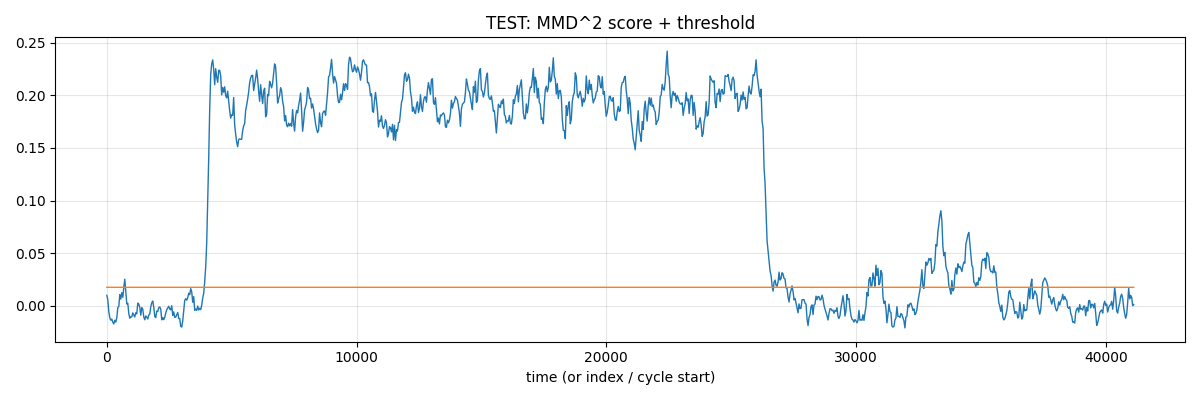

In [60]:

# ============================================================
# ⑦ テストデータで確認：ユーザー設定（このステップで必要なもの）
# ============================================================
# ラベルがある場合、区間色分けをするか
SHADE_TEST_LABELS = True

# 流すサンプル数を制限したい場合
MAX_STREAM_TEST = None  # 例: 50000。制限しないなら None。


# ============================================================
# ⑦ 実装
# ============================================================
df_log_test = run_stream(cd, X_test_std, t_test_s, y_test_s, MAX_STREAM_TEST)

plot_mmd_log(df_log_test, title="TEST: MMD^2 score" + (" + threshold" if USE_THRESHOLD else ""),
             use_threshold=USE_THRESHOLD, shade_labels=SHADE_TEST_LABELS)

# ラベルがある場合：ラベル別に平均スコアを要約（複数ラベル対応）
if df_log_test["label"].notna().any():
    print("\n=== Mean MMD^2 by label (TEST) ===")
    print(df_log_test.dropna(subset=["label"]).groupby("label")["mmd2"].mean().sort_values(ascending=False))

# 追加：ログ保存（必要なら有効化）
# OUT_DIR = Path(r".\out_mmd"); OUT_DIR.mkdir(parents=True, exist_ok=True)
# df_log_train.to_csv(OUT_DIR / "mmd_log_train.csv", index=False)
# df_log_test.to_csv(OUT_DIR / "mmd_log_test.csv", index=False)
# if period_summary is not None:
#     period_summary.to_csv(OUT_DIR / "period_summary.csv", index=False)
